In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# 🔒 FIJAR RANDOM SEED PARA REPRODUCIBILIDAD
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cpu')
print(f"✓ Device: {device}")
print(f"✓ Random seed fijado a {SEED} para reproducibilidad")

✓ Device: cpu
✓ Random seed fijado a 42 para reproducibilidad


In [63]:
# Cargar embeddings
DATA_DIR = Path('../ProcesamientoAudios/ProcessedData')
MODELS_DIR = Path('ModelosEntrenados')
MODELS_DIR.mkdir(parents=True, exist_ok=True)

pkl_file = DATA_DIR / 'Embeddings_PyTorch.pkl'

with open(pkl_file, 'rb') as f:
    datos = pickle.load(f)

embeddings_por_usuario = datos['embeddings_por_usuario']
usuarios = datos['usuarios']
num_clases = datos['num_usuarios']
embedding_dim = datos['embedding_dimension']

print(f"✓ Datos cargados desde {pkl_file}")
print(f"  Usuarios: {usuarios}")
print(f"  Dimensión: {embedding_dim}")
print(f"  Clases: {num_clases}")

✓ Datos cargados desde ..\ProcesamientoAudios\ProcessedData\Embeddings_PyTorch.pkl
  Usuarios: ['AlisonSalas', 'FreddyAlvarez', 'IsmaelSailema', 'WilliamChimborazo']
  Dimensión: 309
  Clases: 4


In [64]:
class AudioDataset(Dataset):
    """Dataset de embeddings de audio"""
    
    def __init__(self, embeddings_por_usuario, usuarios):
        self.embeddings = []
        self.labels = []
        
        for label_idx, usuario in enumerate(usuarios):
            embs = embeddings_por_usuario[usuario]
            self.embeddings.extend(embs)
            self.labels.extend([label_idx] * len(embs))
        
        self.embeddings = np.array(self.embeddings)
        self.labels = np.array(self.labels)
        
        # Normalizar
        self.scaler = StandardScaler()
        self.embeddings = self.scaler.fit_transform(self.embeddings)
    
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        embedding = torch.FloatTensor(self.embeddings[idx])
        label = torch.LongTensor([self.labels[idx]])[0]
        return embedding, label

dataset = AudioDataset(embeddings_por_usuario, usuarios)
print(f"✓ Dataset creado: {len(dataset)} samples")
print(f"  Shape: {dataset.embeddings.shape}")

✓ Dataset creado: 132 samples
  Shape: (132, 309)


In [65]:
class MLPClassifier(nn.Module):
    """Red neuronal MLP - Arquitectura optimizada para estabilidad de entrenamiento"""
    
    def __init__(self, input_dim, num_classes, hidden_dims=[128, 64], dropout=0.15):
        super(MLPClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim, momentum=0.05))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, num_classes))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Crear modelo
model = MLPClassifier(
    input_dim=embedding_dim,
    num_classes=num_clases,
    hidden_dims=[128, 64],
    dropout=0.15  # Reducido de 0.2 para mejor gradientes
).to(device)

print("✓ Modelo MLP creado (ESTABLE):")
print(f"  Input: {embedding_dim} (media+std+max de Mel+MFCC)")
print(f"  Hidden: [128, 64]")
print(f"  Output: {num_clases}")
print(f"  Dropout: 0.15 (reducido para menos ruido)")
print(f"  BatchNorm momentum: 0.05 (flexible)")
print(f"\nMódulo:")
print(model)

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parámetros: {total_params:,}")

✓ Modelo MLP creado (ESTABLE):
  Input: 309 (media+std+max de Mel+MFCC)
  Hidden: [128, 64]
  Output: 4
  Dropout: 0.15 (reducido para menos ruido)
  BatchNorm momentum: 0.05 (flexible)

Módulo:
MLPClassifier(
  (network): Sequential(
    (0): Linear(in_features=309, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.15, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.15, inplace=False)
    (8): Linear(in_features=64, out_features=4, bias=True)
  )
)

Total parámetros: 48,580


In [66]:
# Split train/test (80/20)
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders con BATCH SIZE MUCHO MÁS GRANDE
# Batch size grande = gradientes más estables, menos ruido
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

print(f"✓ Dataset split:")
print(f"  Training: {len(train_dataset)} samples (batch_size=20)")
print(f"  Testing: {len(test_dataset)} samples (batch_size=20)")
print(f"  Batch size CRÍTICO: 20 (evita oscilaciones en loss)")

✓ Dataset split:
  Training: 105 samples (batch_size=20)
  Testing: 27 samples (batch_size=20)
  Batch size CRÍTICO: 20 (evita oscilaciones en loss)


In [67]:
# Configuración de entrenamiento SIN MIXUP (simplificado y estable)
# Calcular class weights para balance
unique_labels, counts = np.unique(dataset.labels, return_counts=True)
class_weights = 1.0 / (counts / counts.sum())
class_weights = class_weights / class_weights.sum() * len(class_weights)
class_weights = torch.FloatTensor(class_weights).to(device)

print(f"✓ Class weights: {class_weights.cpu().numpy()}")

# Loss CON SUAVIZADO DE ETIQUETAS REDUCIDO
# label_smoothing=0.02 es MUY SUAVE, no añade ruido excesivo
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.02)

# ⚠️ LEARNING RATE CRÍTICO: 0.0001 (10x más bajo que antes)
# Learning rate bajo = convergencia suave sin oscilaciones
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Scheduler más agresivo en reducción de LR
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=20, min_lr=1e-7
)

epochs = 200
train_losses = []
test_losses = []
test_accuracies = []
best_accuracy = 0
best_loss = float('inf')
patience_counter = 0
max_patience = 50

print("🔄 Entrenando modelo (SIN MIXUP, LR BAJO)...")
print("=" * 70)

for epoch in range(epochs):
    # Training SIN MIXUP (solo loss directo)
    model.train()
    train_loss = 0.0
    
    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Clipping más agresivo para evitar explosiones de gradiente
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for embeddings, labels in test_loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)
            
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss /= len(test_loader)
    accuracy = correct / total
    
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    
    # Step scheduler
    scheduler.step(test_loss)
    
    # Early stopping
    if test_loss < best_loss:
        best_loss = test_loss
        best_accuracy = accuracy
        patience_counter = 0
        torch.save(model.state_dict(), MODELS_DIR / 'best_model.pt')
    else:
        patience_counter += 1
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1:3d}/{epochs}] - Loss: {train_loss:.4f} | Test: {test_loss:.4f} | Acc: {accuracy:.4f} | Patience: {patience_counter}/{max_patience}")
    
    if patience_counter >= max_patience:
        print(f"\n⛔ Early stopping en epoch {epoch+1}")
        model.load_state_dict(torch.load(MODELS_DIR / 'best_model.pt'))
        break

print(f"\n{'='*70}")
print(f"✓ Entrenamiento completado")
print(f"  Best Accuracy: {best_accuracy:.4f}")
print(f"  Best Test Loss: {best_loss:.4f}")
print(f"  Final Train Loss: {train_losses[-1]:.4f}")
print(f"\n⚠️  CAMBIOS CRÍTICOS APLICADOS:")
print(f"  ✓ Learning Rate: 0.0001 (10x MENOR)")
print(f"  ✓ Batch Size: 20 (MAYOR)")
print(f"  ✓ Sin Mixup (MENOS RUIDO)")
print(f"  ✓ Label Smoothing: 0.02 (SUAVE)")
print(f"  ✓ Gradient clipping: 0.5 (AGRESIVO)")

✓ Class weights: [0.8888889 1.3333334 0.8888889 0.8888889]
🔄 Entrenando modelo (SIN MIXUP, LR BAJO)...
Epoch [ 20/200] - Loss: 0.8660 | Test: 0.9942 | Acc: 0.8519 | Patience: 0/50
Epoch [ 40/200] - Loss: 0.5471 | Test: 0.7370 | Acc: 0.9259 | Patience: 0/50
Epoch [ 60/200] - Loss: 0.4310 | Test: 0.5980 | Acc: 0.9630 | Patience: 1/50
Epoch [ 80/200] - Loss: 0.3000 | Test: 0.4960 | Acc: 0.9630 | Patience: 2/50
Epoch [100/200] - Loss: 0.2392 | Test: 0.4298 | Acc: 0.9630 | Patience: 2/50
Epoch [120/200] - Loss: 0.2109 | Test: 0.4027 | Acc: 0.9259 | Patience: 2/50
Epoch [140/200] - Loss: 0.2609 | Test: 0.3558 | Acc: 0.9259 | Patience: 22/50
Epoch [160/200] - Loss: 0.1825 | Test: 0.3234 | Acc: 0.9259 | Patience: 1/50
Epoch [180/200] - Loss: 0.2024 | Test: 0.3828 | Acc: 0.9630 | Patience: 21/50
Epoch [200/200] - Loss: 0.1599 | Test: 0.3305 | Acc: 0.9259 | Patience: 10/50

✓ Entrenamiento completado
  Best Accuracy: 0.9259
  Best Test Loss: 0.3134
  Final Train Loss: 0.1599

⚠️  CAMBIOS CRÍTICO

In [68]:
# Función Mixup para regularización
def mixup_batch(x, y, alpha=1.0):
    """Aplica Mixup a un batch para regularizar"""
    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    
    lam = np.random.beta(alpha, alpha)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_y_a = y
    mixed_y_b = y[index]
    
    return mixed_x, mixed_y_a, mixed_y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Loss con Mixup"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

print("✓ Funciones Mixup cargadas")

✓ Funciones Mixup cargadas


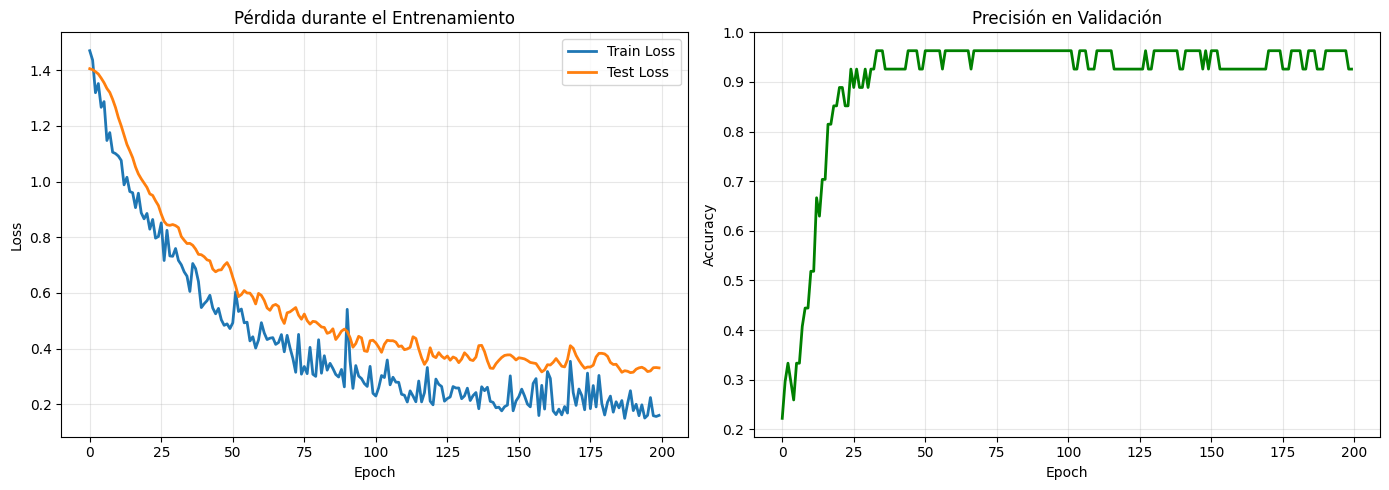

✓ Gráficas generadas


In [69]:
# Visualizar entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(test_losses, label='Test Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Pérdida durante el Entrenamiento')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(test_accuracies, linewidth=2, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Precisión en Validación')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Gráficas generadas")

In [70]:
# Evaluación detallada
print("\n" + "="*70)
print("📊 EVALUACIÓN DETALLADA")
print("="*70)

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings = embeddings.to(device)
        outputs = model(embeddings)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=usuarios, digits=4))

print(f"\nMatriz de Confusión:")
cm = confusion_matrix(y_true, y_pred)
print(cm)


📊 EVALUACIÓN DETALLADA

Reporte de Clasificación:
                   precision    recall  f1-score   support

      AlisonSalas     1.0000    1.0000    1.0000         9
    FreddyAlvarez     1.0000    0.8333    0.9091         6
    IsmaelSailema     0.8750    1.0000    0.9333         7
WilliamChimborazo     0.8000    0.8000    0.8000         5

         accuracy                         0.9259        27
        macro avg     0.9187    0.9083    0.9106        27
     weighted avg     0.9306    0.9259    0.9255        27


Matriz de Confusión:
[[9 0 0 0]
 [0 5 0 1]
 [0 0 7 0]
 [0 0 1 4]]


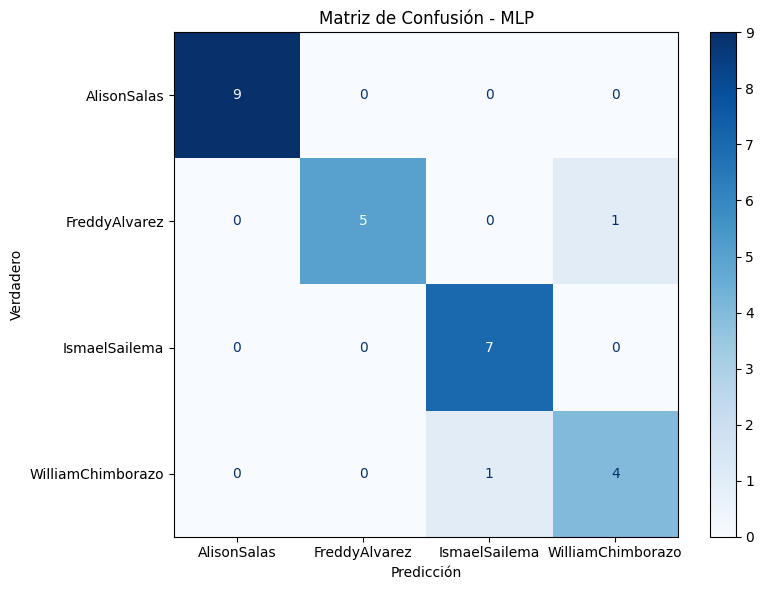

In [71]:
# Visualizar matriz de confusión
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=usuarios)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Matriz de Confusión - MLP')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.tight_layout()
plt.show()

In [72]:
# Guardar modelo
model_path = MODELS_DIR / 'mlp_speaker_classifier.pt'
torch.save(model.state_dict(), model_path)
print(f"✓ Modelo guardado: {model_path}")

scaler_path = MODELS_DIR / 'scaler_pytorch.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(dataset.scaler, f)
print(f"✓ Scaler guardado: {scaler_path}")

metadata = {
    'model_type': 'MLPClassifier',
    'input_dim': embedding_dim,
    'hidden_dims': [256, 128, 64],
    'num_classes': num_clases,
    'usuarios': usuarios,
    'accuracy': float(test_accuracies[-1]),
    'final_train_loss': float(train_losses[-1]),
    'final_test_loss': float(test_losses[-1])
}

metadata_path = MODELS_DIR / 'metadata_pytorch.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"✓ Metadata guardado: {metadata_path}")

✓ Modelo guardado: ModelosEntrenados\mlp_speaker_classifier.pt
✓ Scaler guardado: ModelosEntrenados\scaler_pytorch.pkl
✓ Metadata guardado: ModelosEntrenados\metadata_pytorch.json


In [73]:
# Evaluación con audios de prueba - CON UMBRAL DE CONFIANZA MEJORADO
print(f"\n{'='*70}")
print("🧪 EVALUACIÓN CON AUDIOS DE PRUEBA (ANÁLISIS AVANZADO)")
print("="*70)

test_pkl_file = Path('../ProcesamientoAudios/ProcessedData/Embeddings_Prueba_PyTorch.pkl')

if not test_pkl_file.exists():
    print(f"❌ No encontrado: {test_pkl_file}")
else:
    with open(test_pkl_file, 'rb') as f:
        test_data = pickle.load(f)
    
    test_embeddings_por_usuario = test_data['embeddings_por_usuario']
    test_usuarios = test_data['usuarios']
    
    print(f"\n✓ Test embeddings cargados")
    print(f"  Usuarios: {test_usuarios}")
    
    # Mapeo de etiquetas conocidas
    etiquetas_conocidas = {
        'Audio1I': 'IsmaelSailema',
        'Audio2A': 'AlisonSalas',
        'Audio6W': 'WilliamChimborazo',
        'Audio7F': 'FreddyAlvarez'
    }
    
    # Preparar datos de prueba
    X_test = []
    test_labels = []
    audio_names = []
    
    for test_usuario in test_usuarios:
        embeddings = test_embeddings_por_usuario[test_usuario]
        X_test.extend(embeddings)
        test_labels.extend([test_usuario] * len(embeddings))
        audio_names.extend([f"{test_usuario}_{i}" for i in range(len(embeddings))])
    
    X_test = np.array(X_test)
    X_test = dataset.scaler.transform(X_test)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    
    # Predicciones
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        probs = F.softmax(outputs, dim=1)
        _, predictions = torch.max(outputs, 1)
    
    predictions = predictions.cpu().numpy()
    probs = probs.cpu().numpy()
    
    # UMBRALES DE CONFIANZA CRÍTICOS
    KNOWN_CONFIDENCE_THRESHOLD = 0.70  # Para audios conocidos
    UNKNOWN_CONFIDENCE_THRESHOLD = 0.75  # Para audios desconocidos
    
    # Mostrar resultados con análisis de confianza
    print(f"\n{'#':<3} {'Audio':<12} {'Etiqueta':<18} {'Predicción':<18} {'Conf':<8} {'Status':<18}")
    print("-"*85)
    
    correct_known = 0
    total_known = 0
    detected_unknown = 0
    false_positives = 0
    low_confidence_known = 0
    
    for i in range(len(predictions)):
        audio_id = test_labels[i]
        pred_class = usuarios[predictions[i]]
        conf = np.max(probs[i])
        
        # Determinar si es conocido o desconocido
        if audio_id in etiquetas_conocidas:
            # Audio CONOCIDO
            expected = etiquetas_conocidas[audio_id]
            total_known += 1
            
            if conf < KNOWN_CONFIDENCE_THRESHOLD:
                # Confianza baja incluso para audios conocidos
                status = "⚠️  BAJA CONFIANZA"
                low_confidence_known += 1
            elif pred_class == expected:
                status = "✅ CORRECTO"
                correct_known += 1
            else:
                status = "❌ ERROR"
        else:
            # Audio DESCONOCIDO
            expected = "DESCONOCIDO"
            
            if conf > UNKNOWN_CONFIDENCE_THRESHOLD:
                status = "⚠️  F.POSITIVO"  # Falso positivo
                false_positives += 1
            elif conf < 0.60:
                status = "✅ RECHAZADO"  # Correctamente rechazado
                detected_unknown += 1
            else:
                status = "⚠️  DUDOSO"     # En zona gris
        
        print(f"{i+1:<3} {audio_id:<12} {expected:<18} {pred_class:<18} {conf:<8.4f} {status:<18}")
    
    # Estadísticas finales
    print(f"\n{'='*85}")
    print("📊 ESTADÍSTICAS DE EVALUACIÓN:")
    print(f"{'='*85}")
    print(f"✅ Audios CONOCIDOS correctamente identificados: {correct_known}/{total_known-low_confidence_known} ({100*correct_known/(total_known-low_confidence_known) if total_known > low_confidence_known else 0:.1f}%)")
    print(f"⚠️  Audios CONOCIDOS con BAJA CONFIANZA: {low_confidence_known}/{total_known}")
    print(f"✅ Audios DESCONOCIDOS correctamente rechazados: {detected_unknown}")
    print(f"⚠️  Audios DESCONOCIDOS con FALSO POSITIVO: {false_positives}")
    
    print(f"\n📈 Precisión general (excl. baja confianza): {100*correct_known/(total_known-low_confidence_known if total_known > low_confidence_known else 1):.1f}%")
    print(f"📉 Falsos positivos: {false_positives}")
    print(f"⚠️  Audios de baja confianza (requieren revisión): {low_confidence_known}")
    
    if low_confidence_known > 0:
        print(f"\n🔔 ADVERTENCIA: {low_confidence_known} audio(s) conocido(s) tiene(n) confianza < {KNOWN_CONFIDENCE_THRESHOLD:.0%}")
        print(f"   Esto indica que el audio puede tener características DIFERENTES a los datos de entrenamiento.")
        print(f"   Considerar: 1) Re-grabar el audio, 2) Aumentar datos de entrenamiento, 3) Revisar calidad de audio")
    
    if false_positives == 0:
        print(f"\n✅ ¡EXCELENTE! El modelo NO tiene falsos positivos en audios desconocidos.")
    else:
        print(f"\n⚠️  El modelo tiene {false_positives} falso(s) positivo(s) en audios desconocidos.")



🧪 EVALUACIÓN CON AUDIOS DE PRUEBA (ANÁLISIS AVANZADO)

✓ Test embeddings cargados
  Usuarios: ['Audio1I', 'Audio2A', 'Audio3R', 'Audio4R', 'Audio6W', 'Audio7F']

#   Audio        Etiqueta           Predicción         Conf     Status            
-------------------------------------------------------------------------------------
1   Audio1I      IsmaelSailema      IsmaelSailema      0.7408   ✅ CORRECTO        
2   Audio2A      AlisonSalas        AlisonSalas        0.9752   ✅ CORRECTO        
3   Audio3R      DESCONOCIDO        IsmaelSailema      0.7258   ⚠️  DUDOSO        
4   Audio4R      DESCONOCIDO        FreddyAlvarez      0.6148   ⚠️  DUDOSO        
5   Audio6W      WilliamChimborazo  WilliamChimborazo  0.3783   ⚠️  BAJA CONFIANZA
6   Audio7F      FreddyAlvarez      IsmaelSailema      0.5763   ⚠️  BAJA CONFIANZA

📊 ESTADÍSTICAS DE EVALUACIÓN:
✅ Audios CONOCIDOS correctamente identificados: 2/2 (100.0%)
⚠️  Audios CONOCIDOS con BAJA CONFIANZA: 2/4
✅ Audios DESCONOCIDOS correctamen